In [65]:
# imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm
from PIL import Image

In [66]:
# constants
DATA_DIR = 'Hey-Waldo'  # Path to the Hey-Waldo dataset
FEATURES_DIR = 'waldo-features'  # Path to the features dataset
IMAGE_SIZE = 64  # Choose one size for simplicity (e.g., 256x256)
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [67]:
# CNN model for individual feature detection
class FeatureCNN(nn.Module):
    def __init__(self, num_classes):
        super(FeatureCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(256 * IMAGE_SIZE // 8 * IMAGE_SIZE // 8, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 256 * IMAGE_SIZE // 8 * IMAGE_SIZE // 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [68]:
class WaldoDataset(Dataset):
    def __init__(self, image_folder, label, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Iterate through the directories and ensure we're working with directories
        for count, feature in enumerate(os.listdir(image_folder)):
            feature_path = os.path.join(image_folder, feature)
            print(f"Loading {feature} from {feature_path}")
            print(f" * Label: {label}")

            self.image_paths.append(feature_path)
            self.labels.append(label)

        # Debug print to verify image loading
        print(f"Loaded {len(self.image_paths)} images from {image_folder}")
        print(f"Labels: {self.labels}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


In [69]:
# Preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [70]:
# Datasets for individual features and general Waldo
feature_datasets = {}
feature_models = {}
print(f"Full path to waldo-features: {os.path.abspath(FEATURES_DIR)}")
print(os.path.join(FEATURES_DIR, 'glasses'))


for feature in ['glasses', 'shirt', 'hat', 'face']:
    label = 0
    dataset = WaldoDataset(os.path.join(FEATURES_DIR, feature), label, transform=transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    model = FeatureCNN(num_classes=2).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Training Loop
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        for inputs, labels in tqdm(dataloader, desc=f"Training {feature} model"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(dataloader)
        epoch_accuracy = correct_preds / total_preds
        print(f"[{feature}] Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f}")
    
    feature_models[feature] = model
    
    # increment label so each feature has a unique label
    label += 1

Full path to waldo-features: c:\Users\Caleb\Documents\College\Sophomore Year\Semester 2\Data and Models II\Project\Waldo-Finder\waldo-features
waldo-features\glasses
Loading glasses_0.png from waldo-features\glasses\glasses_0.png
 * Label: 0
Loading glasses_1.png from waldo-features\glasses\glasses_1.png
 * Label: 0
Loading glasses_2.png from waldo-features\glasses\glasses_2.png
 * Label: 0
Loading glasses_3.png from waldo-features\glasses\glasses_3.png
 * Label: 0
Loading glasses_4.png from waldo-features\glasses\glasses_4.png
 * Label: 0
Loading glasses_5.png from waldo-features\glasses\glasses_5.png
 * Label: 0
Loading glasses_6.png from waldo-features\glasses\glasses_6.png
 * Label: 0
Loading glasses_7.png from waldo-features\glasses\glasses_7.png
 * Label: 0
Loading glasses_8.png from waldo-features\glasses\glasses_8.png
 * Label: 0
Loading glasses_9.png from waldo-features\glasses\glasses_9.png
 * Label: 0
Loaded 10 images from waldo-features\glasses
Labels: [0, 0, 0, 0, 0, 0, 0,

Training glasses model: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


[glasses] Epoch 1/10 - Loss: 0.7521 - Accuracy: 0.0000


Training glasses model: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


[glasses] Epoch 2/10 - Loss: 0.3827 - Accuracy: 1.0000


Training glasses model: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


[glasses] Epoch 3/10 - Loss: 0.2044 - Accuracy: 1.0000


Training glasses model: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


[glasses] Epoch 4/10 - Loss: 0.0936 - Accuracy: 1.0000


Training glasses model: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


[glasses] Epoch 5/10 - Loss: 0.0374 - Accuracy: 1.0000


Training glasses model: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


[glasses] Epoch 6/10 - Loss: 0.0136 - Accuracy: 1.0000


Training glasses model: 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


[glasses] Epoch 7/10 - Loss: 0.0047 - Accuracy: 1.0000


Training glasses model: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


[glasses] Epoch 8/10 - Loss: 0.0016 - Accuracy: 1.0000


Training glasses model: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


[glasses] Epoch 9/10 - Loss: 0.0005 - Accuracy: 1.0000


Training glasses model: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


[glasses] Epoch 10/10 - Loss: 0.0002 - Accuracy: 1.0000
Loading shirt_0.png from waldo-features\shirt\shirt_0.png
 * Label: 0
Loading shirt_1.png from waldo-features\shirt\shirt_1.png
 * Label: 0
Loading shirt_2.png from waldo-features\shirt\shirt_2.png
 * Label: 0
Loading shirt_3.png from waldo-features\shirt\shirt_3.png
 * Label: 0
Loading shirt_4.png from waldo-features\shirt\shirt_4.png
 * Label: 0
Loading shirt_5.png from waldo-features\shirt\shirt_5.png
 * Label: 0
Loading shirt_6.png from waldo-features\shirt\shirt_6.png
 * Label: 0
Loading shirt_7.png from waldo-features\shirt\shirt_7.png
 * Label: 0
Loading shirt_8.png from waldo-features\shirt\shirt_8.png
 * Label: 0
Loading shirt_9.png from waldo-features\shirt\shirt_9.png
 * Label: 0
Loaded 10 images from waldo-features\shirt
Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Training shirt model: 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]


[shirt] Epoch 1/10 - Loss: 0.7375 - Accuracy: 0.0000


Training shirt model: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


[shirt] Epoch 2/10 - Loss: 0.3058 - Accuracy: 1.0000


Training shirt model: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


[shirt] Epoch 3/10 - Loss: 0.1220 - Accuracy: 1.0000


Training shirt model: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


[shirt] Epoch 4/10 - Loss: 0.0412 - Accuracy: 1.0000


Training shirt model: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


[shirt] Epoch 5/10 - Loss: 0.0127 - Accuracy: 1.0000


Training shirt model: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


[shirt] Epoch 6/10 - Loss: 0.0038 - Accuracy: 1.0000


Training shirt model: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


[shirt] Epoch 7/10 - Loss: 0.0011 - Accuracy: 1.0000


Training shirt model: 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


[shirt] Epoch 8/10 - Loss: 0.0004 - Accuracy: 1.0000


Training shirt model: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


[shirt] Epoch 9/10 - Loss: 0.0001 - Accuracy: 1.0000


Training shirt model: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


[shirt] Epoch 10/10 - Loss: 0.0000 - Accuracy: 1.0000
Loading hat_0.png from waldo-features\hat\hat_0.png
 * Label: 0
Loading hat_1.png from waldo-features\hat\hat_1.png
 * Label: 0
Loading hat_2.png from waldo-features\hat\hat_2.png
 * Label: 0
Loading hat_3.png from waldo-features\hat\hat_3.png
 * Label: 0
Loading hat_4.png from waldo-features\hat\hat_4.png
 * Label: 0
Loading hat_5.png from waldo-features\hat\hat_5.png
 * Label: 0
Loading hat_6.png from waldo-features\hat\hat_6.png
 * Label: 0
Loading hat_7.png from waldo-features\hat\hat_7.png
 * Label: 0
Loading hat_8.png from waldo-features\hat\hat_8.png
 * Label: 0
Loading hat_9.png from waldo-features\hat\hat_9.png
 * Label: 0
Loaded 10 images from waldo-features\hat
Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Training hat model: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


[hat] Epoch 1/10 - Loss: 0.7354 - Accuracy: 0.0000


Training hat model: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


[hat] Epoch 2/10 - Loss: 0.4083 - Accuracy: 1.0000


Training hat model: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


[hat] Epoch 3/10 - Loss: 0.2233 - Accuracy: 1.0000


Training hat model: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


[hat] Epoch 4/10 - Loss: 0.0994 - Accuracy: 1.0000


Training hat model: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


[hat] Epoch 5/10 - Loss: 0.0358 - Accuracy: 1.0000


Training hat model: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


[hat] Epoch 6/10 - Loss: 0.0111 - Accuracy: 1.0000


Training hat model: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


[hat] Epoch 7/10 - Loss: 0.0031 - Accuracy: 1.0000


Training hat model: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


[hat] Epoch 8/10 - Loss: 0.0008 - Accuracy: 1.0000


Training hat model: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


[hat] Epoch 9/10 - Loss: 0.0002 - Accuracy: 1.0000


Training hat model: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


[hat] Epoch 10/10 - Loss: 0.0001 - Accuracy: 1.0000
Loading face_0.png from waldo-features\face\face_0.png
 * Label: 0
Loading face_1.png from waldo-features\face\face_1.png
 * Label: 0
Loading face_2.png from waldo-features\face\face_2.png
 * Label: 0
Loading face_3.png from waldo-features\face\face_3.png
 * Label: 0
Loading face_4.png from waldo-features\face\face_4.png
 * Label: 0
Loading face_5.png from waldo-features\face\face_5.png
 * Label: 0
Loading face_6.png from waldo-features\face\face_6.png
 * Label: 0
Loading face_7.png from waldo-features\face\face_7.png
 * Label: 0
Loading face_8.png from waldo-features\face\face_8.png
 * Label: 0
Loading face_9.png from waldo-features\face\face_9.png
 * Label: 0
Loaded 10 images from waldo-features\face
Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Training face model: 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


[face] Epoch 1/10 - Loss: 0.6491 - Accuracy: 1.0000


Training face model: 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


[face] Epoch 2/10 - Loss: 0.1965 - Accuracy: 1.0000


Training face model: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


[face] Epoch 3/10 - Loss: 0.0556 - Accuracy: 1.0000


Training face model: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


[face] Epoch 4/10 - Loss: 0.0140 - Accuracy: 1.0000


Training face model: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


[face] Epoch 5/10 - Loss: 0.0035 - Accuracy: 1.0000


Training face model: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


[face] Epoch 6/10 - Loss: 0.0009 - Accuracy: 1.0000


Training face model: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


[face] Epoch 7/10 - Loss: 0.0002 - Accuracy: 1.0000


Training face model: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


[face] Epoch 8/10 - Loss: 0.0001 - Accuracy: 1.0000


Training face model: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


[face] Epoch 9/10 - Loss: 0.0000 - Accuracy: 1.0000


Training face model: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]

[face] Epoch 10/10 - Loss: 0.0000 - Accuracy: 1.0000


In [71]:
#debugging
from PIL import Image

image_path = "waldo-features/glasses/glasses_0.png"  # Update with an actual image path
try:
    img = Image.open(image_path)
    img.verify()  # Verify that the image is valid
    print(f"Image {image_path} is valid.")
except Exception as e:
    print(f"Error with {image_path}: {e}")

Image waldo-features/glasses/glasses_0.png is valid.


In [72]:
import os
from torch.utils.data import Dataset
from PIL import Image

class WaldoNotWaldoDataset(Dataset):
    def __init__(self, image_folder, transform=None, notwaldo_sample_rate=10):
        self.image_folder = image_folder
        self.transform = transform
        self.notwaldo_sample_rate = notwaldo_sample_rate  # Every 10th notwaldo image
        self.image_paths = []
        self.labels = []

        # Iterate through 'waldo' and 'notwaldo' folders
        for label, category in enumerate(['waldo', 'notwaldo']):
            category_path = os.path.join(image_folder, category)
            print(f"Loading {category} images from {category_path}")
            if os.path.isdir(category_path):
                img_names = os.listdir(category_path)
                
                if category == 'waldo':
                    # Add all waldo images
                    for img_name in img_names:
                        img_path = os.path.join(category_path, img_name)
                        if os.path.isfile(img_path):
                            self.image_paths.append(img_path)
                            self.labels.append(label)
                elif category == 'notwaldo':
                    # Add every nth notwaldo image (e.g., every 10th image)
                    for idx, img_name in enumerate(img_names):
                        if idx % self.notwaldo_sample_rate == 0:
                            img_path = os.path.join(category_path, img_name)
                            if os.path.isfile(img_path):
                                self.image_paths.append(img_path)
                                self.labels.append(label)

        # Debug print to verify image loading
        print(f"Loaded {len(self.image_paths)} images from {image_folder}")
        print(f"Labels: {self.labels}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


In [73]:
# General Waldo vs Not-Waldo CNN
dataset = WaldoNotWaldoDataset(os.path.join(DATA_DIR, '64'), transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = FeatureCNN(num_classes=2).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    for inputs, labels in tqdm(dataloader, desc="Training Waldo vs Not-Waldo model"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct_preds / total_preds
    print(f"[Waldo] Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f}")


Loading waldo images from Hey-Waldo\64\waldo
Loading notwaldo images from Hey-Waldo\64\notwaldo
Loaded 573 images from Hey-Waldo\64
Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

Training Waldo vs Not-Waldo model: 100%|██████████| 18/18 [00:14<00:00,  1.26it/s]


[Waldo] Epoch 1/10 - Loss: 0.2927 - Accuracy: 0.9162


Training Waldo vs Not-Waldo model: 100%|██████████| 18/18 [00:03<00:00,  5.54it/s]


[Waldo] Epoch 2/10 - Loss: 0.2507 - Accuracy: 0.9319


Training Waldo vs Not-Waldo model: 100%|██████████| 18/18 [00:03<00:00,  5.42it/s]


[Waldo] Epoch 3/10 - Loss: 0.2423 - Accuracy: 0.9319


Training Waldo vs Not-Waldo model: 100%|██████████| 18/18 [00:03<00:00,  5.15it/s]


[Waldo] Epoch 4/10 - Loss: 0.2246 - Accuracy: 0.9319


Training Waldo vs Not-Waldo model: 100%|██████████| 18/18 [00:03<00:00,  5.61it/s]


[Waldo] Epoch 5/10 - Loss: 0.2200 - Accuracy: 0.9319


Training Waldo vs Not-Waldo model: 100%|██████████| 18/18 [00:03<00:00,  5.60it/s]


[Waldo] Epoch 6/10 - Loss: 0.1934 - Accuracy: 0.9319


Training Waldo vs Not-Waldo model: 100%|██████████| 18/18 [00:03<00:00,  5.38it/s]


[Waldo] Epoch 7/10 - Loss: 0.1618 - Accuracy: 0.9319


Training Waldo vs Not-Waldo model: 100%|██████████| 18/18 [00:03<00:00,  5.66it/s]


[Waldo] Epoch 8/10 - Loss: 0.1380 - Accuracy: 0.9389


Training Waldo vs Not-Waldo model: 100%|██████████| 18/18 [00:03<00:00,  5.51it/s]


[Waldo] Epoch 9/10 - Loss: 0.1356 - Accuracy: 0.9494


Training Waldo vs Not-Waldo model: 100%|██████████| 18/18 [00:03<00:00,  5.49it/s]

[Waldo] Epoch 10/10 - Loss: 0.0908 - Accuracy: 0.9564


In [ ]:
# Function to perform sliding window over an image
def sliding_window(image, window_size=256, step_size=256):
    h, w, _ = image.shape
    for y in range(0, h - window_size, step_size):
        for x in range(0, w - window_size, step_size):
            yield (x, y, image[y:y + window_size, x:x + window_size])

In [82]:
# Function to run sliding window and generate bounding boxes
def generate_bounding_boxes(model, image, transform, threshold=0.5, window_size=256, step_size=32):
    model.eval()  # Set the model to evaluation mode
    bounding_boxes = []
    heatmap = np.zeros(image.shape[:2])  # Initialize the heatmap to zeros
    
    for (x, y, window) in sliding_window(image, window_size, step_size):
        window_image = Image.fromarray(window)
        window_tensor = transform(window_image).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            outputs = model(window_tensor)  # Get predictions
            probs = torch.softmax(outputs, dim=1)  # Get probabilities for each class
            waldo_prob = probs[0, 1].item()  # Get the probability for the "waldo" class
            
            if waldo_prob > threshold:  # If the probability exceeds the threshold, it's considered a detection
                # Record the bounding box (top-left, bottom-right)
                bounding_boxes.append((x, y, x + window_size, y + window_size))
                heatmap[y:y + window_size, x:x + window_size] += waldo_prob  # Update heatmap

    return bounding_boxes, heatmap

In [83]:
# Function to visualize the image with bounding boxes
def visualize_bounding_boxes(image, bounding_boxes, heatmap=None):
    # Draw bounding boxes on the image
    image_with_boxes = image.copy()
    for (x1, y1, x2, y2) in bounding_boxes:
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (0, 0, 0), 2)  # Green color for boxes
    
    # Optionally, show a heatmap overlaid on the image
    if heatmap is not None:
        plt.imshow(heatmap, cmap='hot', alpha=0.5)  # Overlay heatmap with transparency
        plt.imshow(image_with_boxes)  # Show the image with bounding boxes
    else:
        plt.imshow(image_with_boxes)  # Just show the image with bounding boxes

    plt.axis('off')
    plt.show()

In [84]:
# Load image for testing
test_image = cv2.imread('Hey-Waldo/original-images/1.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
heatmap = np.zeros(test_image.shape[:2])

In [86]:

# # Slide window and apply models
# for (x, y, window) in sliding_window(test_image):
#     window_tensor = transform(Image.fromarray(window)).unsqueeze(0).to(DEVICE)
#     output = model(window_tensor)
#     pred = torch.argmax(output, dim=1).item()
    
#     # Update heatmap for each sliding window
#     if pred == 1:  # Waldo
#         heatmap[y:y + IMAGE_SIZE, x:x + IMAGE_SIZE] += 1

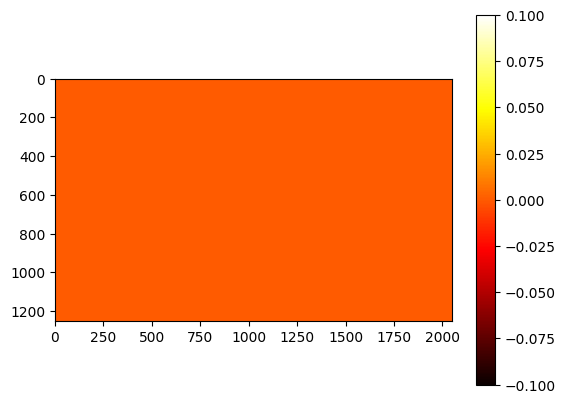

In [87]:
# Normalize heatmap
heatmap = np.clip(heatmap, 0, 1)

# Display heatmap
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

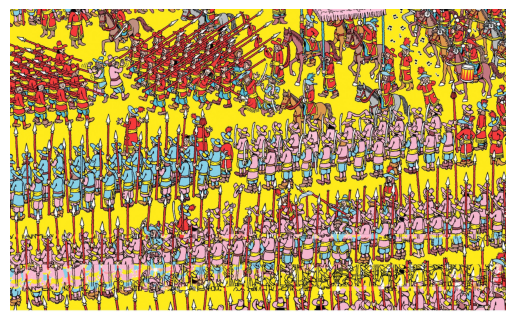

In [90]:
# Example usage
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load the test image (you can change this to your test image path)
test_image = cv2.imread('Hey-Waldo/original-images/1.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Assuming the model is loaded and trained
model = FeatureCNN(num_classes=2).to(DEVICE)  # Example model; make sure to load your trained model

# Run the sliding window and get bounding boxes and heatmap
bounding_boxes, heatmap = generate_bounding_boxes(model, test_image, transform, threshold=0.5)

# Visualize the bounding boxes on the image
visualize_bounding_boxes(test_image, bounding_boxes, heatmap)